In [91]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
from mpl_toolkits.basemap import Basemap

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_downloads.HRRR_S3 import *
from BB_wx_calcs.wind import wind_uv_to_spd
from BB_basemap.draw_maps import *
from BB_MesoWest.MesoWest_STNinfo import get_MW_location_dict
from BB_MesoWest.MesoWest_timeseries import get_mesowest_ts
from BB_MesoWest.MesoWest_percentiles import get_mesowest_percentiles
from BB_data.grid_manager import pluck_point_new

In [139]:
from matplotlib.dates import DateFormatter
formatter = DateFormatter('%b')

import matplotlib as mpl 
two_column = 6.5
one_column = 3.2
twothird_column = 5.5
mpl.rcParams['figure.figsize'] = [two_column, two_column]
mpl.rcParams['figure.titlesize'] = 12
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.05
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
    
mpl.rcParams['savefig.dpi'] = 1000    # 600 for print

In [3]:
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/'
latlon_file = h5py.File(DIR+'OSG_HRRR_latlon.h5', 'r')
lat = latlon_file['latitude'].value
lon = latlon_file['longitude'].value

In [10]:
def get_point_percentiles(DATE):
    ## EPD stands for Emperical Percentile Distribution
    if DATE.day == 1 and DATE.hour == 0:
        print 'Working on', DATE
    
    FILE = 'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % ((variable, DATE.month, DATE.day, DATE.hour))
    
    EPD = np.array([])
    with h5py.File(DIR+FILE, 'r') as f:
        for i in percentiles:
            EPD = np.append(EPD, f["p%02d" % i][x][y])
    
    # Convert Units
    if var == 'TMP:2 m' or var == 'DPT:2 m':
        EPD -= 273.15
    
    return EPD

In [5]:
percentiles = [0, 1, 2, 3, 4, 5, 10, 25, 33, 50, 66, 75, 90, 95, 96, 97, 98, 99, 100]
var = 'UVGRD:10 m'
stn = 'KSLC'
fxx = 0

# Date of interest
leapyear = 2016
DATE = datetime(leapyear, 10, 9)

# Hours
hours = [0, 6, 12, 18]

In [6]:
variable = var.replace(':', '_').replace(' ', '_')
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)

if var == 'TMP:2 m':
    MWvar = 'air_temp'
    label = '2 m Temperature (C)'
elif var == 'DPT:2 m':
    MWvar = 'dew_point_temperature'
    label = '2 m Dew Point Temperature (C)'
elif var == 'UVGRD:10 m':
    MWvar = 'wind_speed'
    label = r'10 m Wind Speed (m s$\mathregular{^{-1}}$)'
elif var == 'UVGRD:80 m':
    MWvar = 'wind_speed'
    label = r'80 m Wind Speed (m s$\mathregular{^{-1}}$)'
else:
    MWvar = ''
    print "NO MATCHING VAR AND MESOWEST VAR"

In [33]:
# Get Time Series Data for each requested Statistic
# HTS is the HRRR-statistic Time Series

# Pluck point nearest MesoWest Station
LD = get_MW_location_dict(stn)
MWlat = LD[stn]['latitude']
MWlon = LD[stn]['longitude']
point = pluck_point_new(MWlat, MWlon, lat, lon)
x = point[0][0]
y = point[1][0]


HR_EPD = get_point_percentiles(DATE)

In [39]:
start = DATE.strftime('%m%d%H')
end = start

MW_per = get_mesowest_percentiles(stn, variable=MWvar, start=start, end=end, percentiles='ALL')
    
MW_EPD = []
for i in percentiles:
    MW_EPD.append(MW_per['p%02d'%i][0])

In [24]:
# Create Map Object
m = Basemap(projection='cyl',
            llcrnrlon=MWlon-.3,  urcrnrlon=MWlon+.3,
            llcrnrlat=MWlat-.3, urcrnrlat=MWlat+.3)

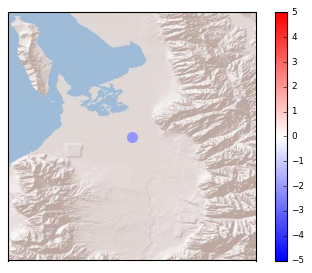

In [65]:
m.arcgisimage(service='World_Shaded_Relief', dpi=100)
m.scatter(MWlon, MWlat,
          c=np.mean(HR_EPD-MW_EPD),
          linewidth=0,
          s=100,
          cmap='bwr',
          vmin=-5, vmax=5)
plt.colorbar()

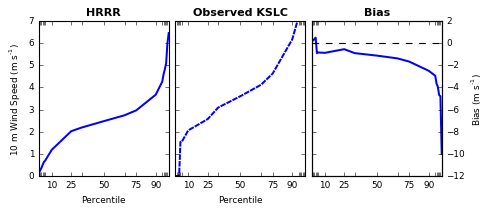

In [62]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=[two_column, 2.5])



# --- Plot HRRR Percentile Curve -------------------------------
plt.sca(ax1)
plt.plot(percentiles, HR_EPD)

plt.xlabel('Percentile')
tick_labels = ['','','','','','', 10, 25, '', 50, '', 75, 90, '', '', '', '','','']
plt.xticks(percentiles, tick_labels)
plt.xlim([0,100])
plt.ylabel('%s' % (label))

if var in ['UVGRD:10 m', 'UVGRD:80 m', 'WIND:10 m', 'GUST:surface']:
    plt.ylim(ymin=0)
else:
    pass

    
plt.title('HRRR', fontweight='semibold')



# --- Plot MesoWest PDF -----------------------------------------
plt.sca(ax2)
plt.plot(percentiles, MW_EPD,
         linestyle='--', dashes=(5, 1))

plt.xlabel('Percentile')
tick_labels = ['','','','','','', 10, 25, '', 50, '', 75, 90, '', '', '', '','','']
plt.xticks(percentiles, tick_labels)
plt.xlim([0,100])

if var in ['UVGRD:10 m', 'UVGRD:80 m', 'WIND:10 m', 'GUST:surface']:
    plt.ylim(ymin=0)
else:
    pass

    
plt.title('Observed %s' % stn, fontweight='semibold')


# --- Plot PDF Difference ---------------------------------------
ax3b = ax3.twinx()
plt.sca(ax3b)
plt.plot(percentiles, HR_EPD-MW_EPD)

plt.axhline(0, c='k', linewidth=1, linestyle='--')
    

plt.xlabel('Percentile')
tick_labels = ['','','','','','', 10, 25, '', 50, '', 75, 90, '', '', '', '','','']
plt.xticks(percentiles, tick_labels)
plt.xlim([0,100])
plt.ylabel(r'Bias %s' % label[label.find('('):])

   
plt.title('Bias', fontweight='semibold')


plt.savefig('./figs/PDF_3pannel_%s_%s_%s' % (stn.upper(), variable, DATE.strftime('m%m_d%d_h00-h06-h12-h18')))

# HRRR validation by MesoWest Emperical Percentile Distribution
Plot the mean error between the HRRR EPD and the Observed EPD

## Utah NWS and RAWS stations

In [117]:
m = draw_Utah_map()

In [106]:
from BB_MesoWest.get_token import my_token
import json

token = my_token()
URL = 'http://api.mesowest.net/v2/stations/metadata?&token=' + token + '&state=UT&network=1,2'
f = urllib2.urlopen(URL)
data_UT = f.read()
data_UT = json.loads(data_UT)

In [ ]:
num = float(len(data_UT['STATION']))
print 'Number of Stations: %.f' % num

In [107]:
start = DATE.strftime('%m%d%H')
end = start

for i, s in enumerate(data_UT['STATION']):
    print '\r>> %.2f%% complete. Working on %s' % (i/num*100, s['STID']),
    sys.stdout.flush()
    # MesoWest EPD
    MW_per = get_mesowest_percentiles(stn, variable=MWvar, start=start, end=end, percentiles='ALL')
    MW_EPD = []
    for i in percentiles:
        MW_EPD.append(MW_per['p%02d'%i][0])
    s['MW_EPD'] = MW_EPD
    
    # HRRR EPD
    MWlat = float(s['LATITUDE'])
    MWlon = float(s['LONGITUDE'])
    point = pluck_point_new(MWlat, MWlon, lat, lon)
    x = point[0][0]
    y = point[1][0]

    HR_EPD = get_point_percentiles(DATE)
    s['HR_EPD'] = HR_EPD

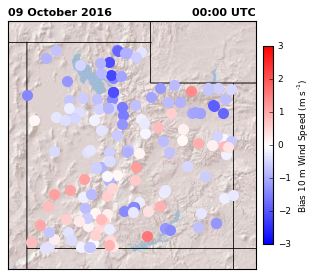

In [118]:
m.arcgisimage(service='World_Shaded_Relief', dpi=100)
m.drawstates()
for s in data_UT['STATION']:
    m.scatter(float(s['LONGITUDE']), float(s['LATITUDE']),
              latlon=True,
              c=np.mean(s['HR_EPD']-s['MW_EPD']),
              linewidth=0,
              s=100,
              cmap='bwr',
              vmin=-3, vmax=3,
              zorder=10)
cb = plt.colorbar(pad=.02, shrink=.8)
cb.set_label('Bias ' + label)
cb.set_ticks([range(-3,4)])

plt.title(DATE.strftime('%d %B %Y'), fontweight='semibold', loc='left')
plt.title(DATE.strftime('%H:%M UTC'), fontweight='semibold', loc='right')

## CONUS NWS stations

In [120]:
m = draw_CONUS_cyl_map()

In [134]:
from BB_MesoWest.get_token import my_token
import json
import time, sys

token = my_token()
URL = 'http://api.mesowest.net/v2/stations/metadata?&token=' + token + '&network=1'
f = urllib2.urlopen(URL)
data = f.read()
data = json.loads(data)

In [135]:
num = float(len(data['STATION']))
print 'Number of Stations: %.f' % num

Number of Stations: 3330


In [136]:
start = DATE.strftime('%m%d%H')
end = start

for i, s in enumerate(data['STATION']):
    try:
        print '\r>> %.2f%% complete. Working on %s' % (i/num*100, s['STID']),
        sys.stdout.flush()
    except:
        pass
    # MesoWest EPD
    MW_per = get_mesowest_percentiles(stn, variable=MWvar, start=start, end=end, percentiles='ALL')
    MW_EPD = []
    for i in percentiles:
        MW_EPD.append(MW_per['p%02d'%i][0])
    s['MW_EPD'] = MW_EPD
    
    # HRRR EPD
    MWlat = float(s['LATITUDE'])
    MWlon = float(s['LONGITUDE'])
    point = pluck_point_new(MWlat, MWlon, lat, lon)
    x = point[0][0]
    y = point[1][0]

    HR_EPD = get_point_percentiles(DATE)
    s['HR_EPD'] = HR_EPD
print 'Done!'

>> 99.97% complete. Working on K1JW Done!


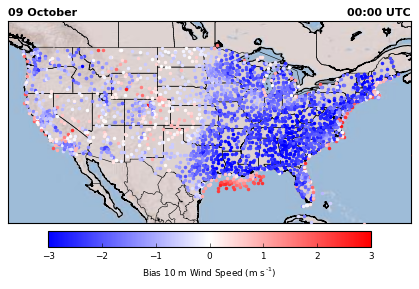

In [144]:
m.arcgisimage(service='World_Shaded_Relief', dpi=100)
m.drawstates()
m.drawcoastlines()
m.drawcountries()
for s in data['STATION']:
    m.scatter(float(s['LONGITUDE']), float(s['LATITUDE']),
              latlon=True,
              c=np.mean(s['HR_EPD']-s['MW_EPD']),
              linewidth=0,
              s=10,
              cmap='bwr',
              vmin=-3, vmax=3,
              zorder=10)
cb = plt.colorbar(pad=.02, shrink=.8, orientation='horizontal')
cb.set_label('Bias ' + label)
cb.set_ticks([range(-3,4)])

plt.title(DATE.strftime('%d %B'), fontweight='semibold', loc='left')
plt.title(DATE.strftime('%H:%M UTC'), fontweight='semibold', loc='right')